In [1]:
import numpy as np
import pandas as pd
import os
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, random_split, DataLoader

from torchvision import datasets, transforms, models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.utils import save_image
from tqdm import tqdm

from transformer_package.models import ViT

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

from pytorch_grad_cam import GradCAMPlusPlus, GradCAM, ScoreCAM

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
BATCH_SIZE = 64
LR = 5e-5
NUM_EPOCHES = 25

mean, std = (0.5,), (0.5,)

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

trainset = datasets.MNIST('../data/MNIST/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

testset = datasets.MNIST('../data/MNIST/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

In [4]:
image_size = 28
channel_size = 1
patch_size = 7
embed_size = 512
num_heads = 8
classes = 10
num_layers = 3
hidden_size = 256
dropout = 0.2

model = ViT(image_size, channel_size, patch_size, embed_size, num_heads, classes, num_layers, hidden_size, dropout=dropout).to(device)
model

ViT(
  (dropout_layer): Dropout(p=0.2, inplace=False)
  (embeddings): Linear(in_features=49, out_features=512, bias=True)
  (encoders): ModuleList(
    (0-2): 3 x VisionEncoder(
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (attention): MultiHeadAttention(
        (dropout_layer): Dropout(p=0.2, inplace=False)
        (Q): Linear(in_features=512, out_features=512, bias=True)
        (K): Linear(in_features=512, out_features=512, bias=True)
        (V): Linear(in_features=512, out_features=512, bias=True)
        (linear): Linear(in_features=512, out_features=512, bias=True)
      )
      (mlp): Sequential(
        (0): Linear(in_features=512, out_features=2048, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.2, inplace=False)
        (3): Linear(in_features=2048, out_features=512, bias=True)
        (4): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (norm): La

In [5]:
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=LR)
loss_hist = {}
loss_hist["train accuracy"] = []
loss_hist["train loss"] = []

In [25]:
for epoch in range(1, NUM_EPOCHES+1):
    model.train()
    
    epoch_train_loss = 0
        
    y_true_train = []
    y_pred_train = []
        
    for batch_idx, (img, labels) in enumerate(tqdm(trainloader)):
        img = img.to(device)
        labels = labels.to(device)
        
        preds = model(img)
        
        loss = criterion(preds, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        y_pred_train.extend(preds.detach().argmax(dim=-1).tolist())
        y_true_train.extend(labels.detach().tolist())
            
        epoch_train_loss += loss.item()
    
    loss_hist["train loss"].append(epoch_train_loss)
    
    total_correct = len([True for x, y in zip(y_pred_train, y_true_train) if x==y])
    total = len(y_pred_train)
    accuracy = total_correct * 100 / total
    
    loss_hist["train accuracy"].append(accuracy)
    
    print("-------------------------------------------------")
    print("Epoch: {} Train mean loss: {:.8f}".format(epoch, epoch_train_loss))
    print("       Train Accuracy%: ", accuracy, "==", total_correct, "/", total)
    print("-------------------------------------------------")

100%|██████████| 938/938 [00:07<00:00, 121.05it/s]


-------------------------------------------------
Epoch: 1 Train mean loss: 637.69394386
       Train Accuracy%:  77.295 == 46377 / 60000
-------------------------------------------------


100%|██████████| 938/938 [00:07<00:00, 122.19it/s]


-------------------------------------------------
Epoch: 2 Train mean loss: 233.68755123
       Train Accuracy%:  92.085 == 55251 / 60000
-------------------------------------------------


100%|██████████| 938/938 [00:07<00:00, 121.75it/s]


-------------------------------------------------
Epoch: 3 Train mean loss: 180.63878004
       Train Accuracy%:  93.93333333333334 == 56360 / 60000
-------------------------------------------------


100%|██████████| 938/938 [00:07<00:00, 126.10it/s]


-------------------------------------------------
Epoch: 4 Train mean loss: 152.43091419
       Train Accuracy%:  94.785 == 56871 / 60000
-------------------------------------------------


100%|██████████| 938/938 [00:07<00:00, 130.36it/s]


-------------------------------------------------
Epoch: 5 Train mean loss: 129.97130387
       Train Accuracy%:  95.545 == 57327 / 60000
-------------------------------------------------


100%|██████████| 938/938 [00:07<00:00, 131.12it/s]


-------------------------------------------------
Epoch: 6 Train mean loss: 113.98339203
       Train Accuracy%:  96.11166666666666 == 57667 / 60000
-------------------------------------------------


100%|██████████| 938/938 [00:07<00:00, 131.16it/s]


-------------------------------------------------
Epoch: 7 Train mean loss: 103.64486249
       Train Accuracy%:  96.5 == 57900 / 60000
-------------------------------------------------


100%|██████████| 938/938 [00:07<00:00, 130.93it/s]


-------------------------------------------------
Epoch: 8 Train mean loss: 94.51674575
       Train Accuracy%:  96.805 == 58083 / 60000
-------------------------------------------------


100%|██████████| 938/938 [00:07<00:00, 130.37it/s]


-------------------------------------------------
Epoch: 9 Train mean loss: 86.55925287
       Train Accuracy%:  97.03 == 58218 / 60000
-------------------------------------------------


100%|██████████| 938/938 [00:07<00:00, 131.27it/s]


-------------------------------------------------
Epoch: 10 Train mean loss: 78.14836636
       Train Accuracy%:  97.36 == 58416 / 60000
-------------------------------------------------


100%|██████████| 938/938 [00:07<00:00, 130.92it/s]


-------------------------------------------------
Epoch: 11 Train mean loss: 74.68496283
       Train Accuracy%:  97.36166666666666 == 58417 / 60000
-------------------------------------------------


100%|██████████| 938/938 [00:07<00:00, 131.05it/s]


-------------------------------------------------
Epoch: 12 Train mean loss: 67.88487327
       Train Accuracy%:  97.63166666666666 == 58579 / 60000
-------------------------------------------------


100%|██████████| 938/938 [00:07<00:00, 130.75it/s]


-------------------------------------------------
Epoch: 13 Train mean loss: 63.87877330
       Train Accuracy%:  97.755 == 58653 / 60000
-------------------------------------------------


100%|██████████| 938/938 [00:07<00:00, 131.30it/s]


-------------------------------------------------
Epoch: 14 Train mean loss: 59.94220055
       Train Accuracy%:  97.93833333333333 == 58763 / 60000
-------------------------------------------------


100%|██████████| 938/938 [00:07<00:00, 130.79it/s]


-------------------------------------------------
Epoch: 15 Train mean loss: 54.55328350
       Train Accuracy%:  98.095 == 58857 / 60000
-------------------------------------------------


100%|██████████| 938/938 [00:07<00:00, 123.91it/s]


-------------------------------------------------
Epoch: 16 Train mean loss: 52.39703346
       Train Accuracy%:  98.16666666666667 == 58900 / 60000
-------------------------------------------------


100%|██████████| 938/938 [00:07<00:00, 122.23it/s]


-------------------------------------------------
Epoch: 17 Train mean loss: 49.46618345
       Train Accuracy%:  98.29166666666667 == 58975 / 60000
-------------------------------------------------


100%|██████████| 938/938 [00:07<00:00, 129.04it/s]


-------------------------------------------------
Epoch: 18 Train mean loss: 45.72311571
       Train Accuracy%:  98.38666666666667 == 59032 / 60000
-------------------------------------------------


100%|██████████| 938/938 [00:07<00:00, 125.64it/s]


-------------------------------------------------
Epoch: 19 Train mean loss: 43.57232298
       Train Accuracy%:  98.47666666666667 == 59086 / 60000
-------------------------------------------------


100%|██████████| 938/938 [00:07<00:00, 122.37it/s]


-------------------------------------------------
Epoch: 20 Train mean loss: 40.64482740
       Train Accuracy%:  98.56833333333333 == 59141 / 60000
-------------------------------------------------


100%|██████████| 938/938 [00:07<00:00, 122.32it/s]


-------------------------------------------------
Epoch: 21 Train mean loss: 39.82463141
       Train Accuracy%:  98.535 == 59121 / 60000
-------------------------------------------------


100%|██████████| 938/938 [00:07<00:00, 121.28it/s]


-------------------------------------------------
Epoch: 22 Train mean loss: 35.82710332
       Train Accuracy%:  98.73666666666666 == 59242 / 60000
-------------------------------------------------


100%|██████████| 938/938 [00:07<00:00, 121.28it/s]


-------------------------------------------------
Epoch: 23 Train mean loss: 35.27858048
       Train Accuracy%:  98.7 == 59220 / 60000
-------------------------------------------------


100%|██████████| 938/938 [00:07<00:00, 123.26it/s]


-------------------------------------------------
Epoch: 24 Train mean loss: 32.28482402
       Train Accuracy%:  98.85666666666667 == 59314 / 60000
-------------------------------------------------


100%|██████████| 938/938 [00:07<00:00, 122.87it/s]

-------------------------------------------------
Epoch: 25 Train mean loss: 30.51618978
       Train Accuracy%:  98.87333333333333 == 59324 / 60000
-------------------------------------------------


In [33]:
torch.save(model.state_dict(), "./model/mnist_vit.pth")

In [6]:
# Load the best model
best_model = ViT(image_size, channel_size, patch_size, embed_size, num_heads, classes, num_layers, hidden_size, dropout=dropout).to(device)
best_model.load_state_dict(torch.load("./model/mnist_vit.pth"))
best_model.eval()

ViT(
  (dropout_layer): Dropout(p=0.2, inplace=False)
  (embeddings): Linear(in_features=49, out_features=512, bias=True)
  (encoders): ModuleList(
    (0-2): 3 x VisionEncoder(
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (attention): MultiHeadAttention(
        (dropout_layer): Dropout(p=0.2, inplace=False)
        (Q): Linear(in_features=512, out_features=512, bias=True)
        (K): Linear(in_features=512, out_features=512, bias=True)
        (V): Linear(in_features=512, out_features=512, bias=True)
        (linear): Linear(in_features=512, out_features=512, bias=True)
      )
      (mlp): Sequential(
        (0): Linear(in_features=512, out_features=2048, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.2, inplace=False)
        (3): Linear(in_features=2048, out_features=512, bias=True)
        (4): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (norm): La

In [7]:
a = testloader.dataset[1]
print(a[0].shape, a[1])

torch.Size([1, 28, 28]) 2


In [8]:
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    accuracy = np.trace(cm) / np.sum(cm)
    print("Accuracy: ", accuracy)

100%|██████████| 157/157 [00:00<00:00, 225.95it/s]


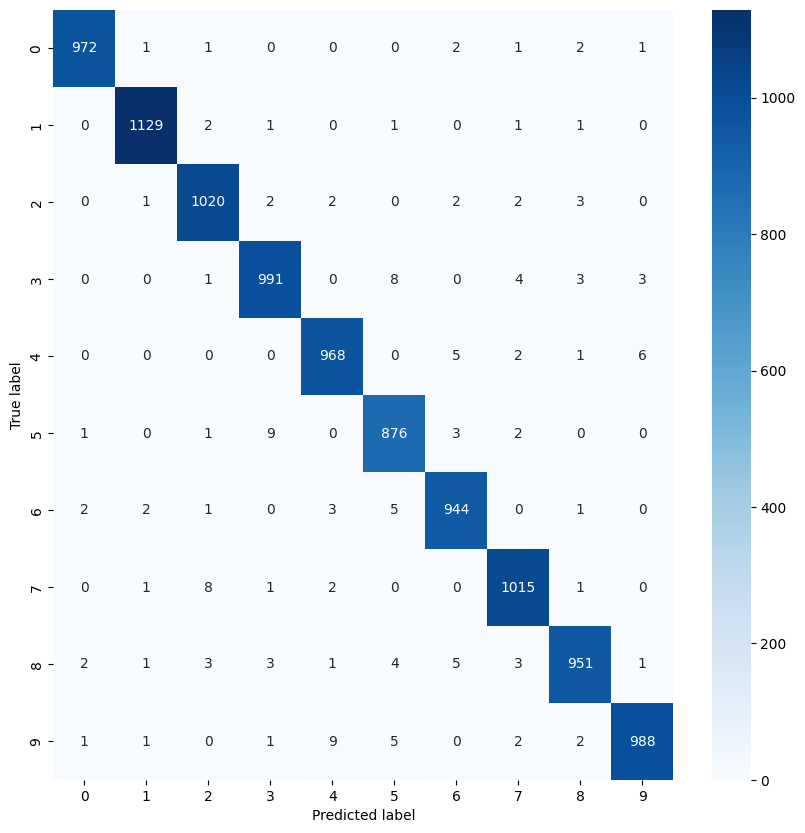

Accuracy:  0.9854


In [9]:
y_true_test = []
y_pred_test = []
with torch.no_grad():
    for batch_idx, (img, labels) in enumerate(tqdm(testloader)):
        img = img.to(device)
        labels = labels.to(device)
        
        preds = best_model(img)
        
        y_pred_test.extend(preds.detach().argmax(dim=-1).tolist())
        y_true_test.extend(labels.detach().tolist())

plot_confusion_matrix(y_true_test, y_pred_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [10]:
def image2cam(image, cam):
    h, w, c = image.shape
    cam -= np.min(cam)
    cam /= np.max(cam)
    cam = cv2.resize(cam, (w,h))

    cam = np.uint8(cam * 255.0)
    img_with_cam = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
    img_with_cam = cv2.cvtColor(img_with_cam, cv2.COLOR_BGR2RGB)
    img_with_cam = img_with_cam *0.5 + (image * 255)
    img_with_cam /= np.max(img_with_cam)

    return img_with_cam

In [11]:
best_model.eval()
best_model

ViT(
  (dropout_layer): Dropout(p=0.2, inplace=False)
  (embeddings): Linear(in_features=49, out_features=512, bias=True)
  (encoders): ModuleList(
    (0-2): 3 x VisionEncoder(
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (attention): MultiHeadAttention(
        (dropout_layer): Dropout(p=0.2, inplace=False)
        (Q): Linear(in_features=512, out_features=512, bias=True)
        (K): Linear(in_features=512, out_features=512, bias=True)
        (V): Linear(in_features=512, out_features=512, bias=True)
        (linear): Linear(in_features=512, out_features=512, bias=True)
      )
      (mlp): Sequential(
        (0): Linear(in_features=512, out_features=2048, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.2, inplace=False)
        (3): Linear(in_features=2048, out_features=512, bias=True)
        (4): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (norm): La

In [63]:
true_idx, false_idx = [], []
for i in range(len(y_true_test)):
    if y_true_test[i] == y_pred_test[i]:
        true_idx.append(i)
    else:
        false_idx.append(i)
def reshape_transform(tensor, height=4, width=4):
    # print(tensor.shape)
    result = tensor[:, 1:, :].reshape(tensor.size(0),
                                      height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.permute(0, 3, 1, 2)
    return result

2545
torch.Size([1, 1, 28, 28]) tensor(-1., device='cuda:0') tensor(1., device='cuda:0')


100%|██████████| 32/32 [00:00<00:00, 431.87it/s]

(1, 28, 28) 0.0 0.9999999


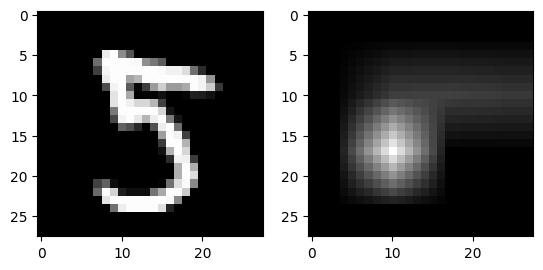

True label:  5 Predicted label:  3


In [65]:
idx = np.random.choice(false_idx)
idx = 2545

print(idx)
img, label = testloader.dataset[idx]
img = img.unsqueeze(0).to(device)
print(img.shape, img.min(), img.max())
plt.subplot(1, 2, 1)
plt.imshow(img[0].cpu().numpy()[0], cmap='gray')

cam = ScoreCAM(
# cam = GradCAMPlusPlus(
# cam = GradCAM(
    model=best_model,
    # target_layers=[best_model.encoders[0].mlp[2]],
    target_layers=[best_model.encoders[0].norm1],
    # target_layers=[best_model.encoders[0].norm1, best_model.encoders[0].norm2, best_model.encoders[0].mlp[2]],
    # target_layers=[best_model.encoders[2].norm1, best_model.encoders[2].norm2, best_model.encoders[2].mlp[2]],
    # target_layers=[best_model.encoders[2]],

    reshape_transform=reshape_transform,
)

attn = cam(
    input_tensor=img,
    targets = None,
)
pred = best_model(img)
print(attn.shape, attn.min(), attn.max())
plt.subplot(1, 2, 2)
plt.imshow(attn[0], cmap='gray')
plt.show()
attn = image2cam(img[0].cpu().numpy()[2::-1].transpose(1, 2, 0), attn[0])

print("True label: ", label, "Predicted label: ", pred.argmax(dim=-1).item())